In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
import re
import yaml
from glob import glob
from math import floor
%matplotlib widget

In [2]:
def match(value, condition):
    if condition is None:
        return True
    if isinstance(condition, (str, int, bool)):
        return value == condition
    if isinstance(condition, re.Pattern):
        return condition.search(value) is not None
    return condition(value)

In [3]:
class Q:
    def __init__(self, condition):
        self._condition = condition
        
    def __repr__(self):
        return 'Q({!r})'.format(self._condition)
    
    def __call__(self, value):
        if isinstance(self._condition, list):
            for c in self._condition:
                if match(value, c):
                    return True
            return False
        if isinstance(self._condition, dict):
            for k, v in self._condition.items():
                if not match(value[k], v):
                    return False
            return True
        return match(value, self._condition)

In [4]:
class Interval:
    def __init__(self, name, begin, end):
        self.name = name
        self.begin = begin
        self.end = end
    
    def __repr__(self):
        return 'Interval({!r}, {!r}, {!r})'.format(self.name, self.begin, self.end)

In [5]:
rootdir = glob('/Users/obulatov/Downloads/quay-io-*f')[0]
events_file = f'{rootdir}/namespaces/openshift-image-registry/core/events.yaml'

with open(events_file) as f:
    events = yaml.safe_load(f)

In [6]:
def event_pod_namespace_name(ev):
    obj = ev.get('involvedObject', {})
    if obj.get('kind') != 'Pod':
        return None
    return '{}/{}'.format(obj.get('namespace', ''), obj.get('name', ''))

def event_timestamp(ev):
    return ev['metadata']['creationTimestamp']

In [7]:
def get_intervals(group_by, select, begin, end):
    active = {}
    for ev in sorted(events['items'], key=lambda x: x['metadata']['creationTimestamp']):
        name = group_by(ev)
        if name is None:
            continue
        if not match(ev, select):
            continue
        if name in active:
            if end(ev):
                yield Interval(name, active[name], ev)
                del active[name]
        else:
            if begin(ev):
                active[name] = ev
            elif end(ev):
                yield Interval(name, None, ev)
    for name, ev in active.items():
        yield(Interval(name, ev, None))

intervals = list(get_intervals(
    group_by=event_pod_namespace_name,
    select=Q({
        'involvedObject': Q({
            'name': re.compile(r'^image-registry-.*'),
        }),
    }),
    begin=Q({'reason': 'Started'}),
    end=Q({'reason': 'Killing'}),
))

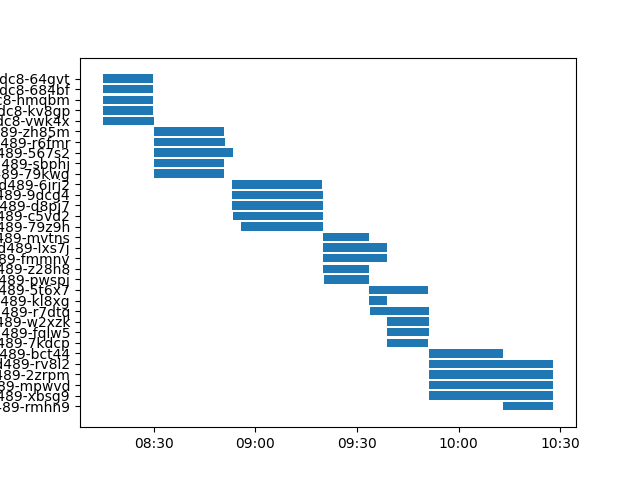

In [8]:
def plot_intervals(ivs):
    if not ivs:
        return
    
    margin = (15*60) / (24*60*60)

    def _begin_timestamp(x):
        if x.begin is None:
            return None
        return dates.datestr2num(event_timestamp(x.begin))

    def _end_timestamp(x):
        if x.end is None:
            return None
        return dates.datestr2num(event_timestamp(x.end))

    min_ = None
    max_ = None
    for iv in ivs:
        for t in (_begin_timestamp(iv), _end_timestamp(iv)):
            if t is not None:
                if min_ is None or t < min_:
                    min_ = t
                if max_ is None or t > max_:
                    max_ = t
    
    ivs_plot = []
    for iv in ivs:
        begin = _begin_timestamp(iv)
        if begin is None:
            begin = min_ - margin
        end = _end_timestamp(iv)
        if end is None:
            end = max_ + margin
        ivs_plot.append(Interval(iv.name, begin, end))
        
    ivs_plot.sort(key=lambda x: x.begin)
    rows = {}
    rows_labels = []
    for iv in ivs_plot:
        if iv.name not in rows:
            rows[iv.name] = len(rows_labels)
            rows_labels.append(iv.name)
    
    from matplotlib.collections import PolyCollection
    verts = []
    for iv in ivs_plot:
        v = [(iv.begin, -rows[iv.name]-.4),
             (iv.begin, -rows[iv.name]+.4),
             (iv.end, -rows[iv.name]+.4),
             (iv.end, -rows[iv.name]-.4)]
        verts.append(v)
    bars = PolyCollection(verts)
    fig, ax = plt.subplots()
    ax.add_collection(bars)
    ax.autoscale()

    xloc = dates.AutoDateLocator(maxticks=10)
    xfmt = dates.AutoDateFormatter(xloc)
    xfmt.scaled[1/(24*60)] = '%H:%M'
    xfmt.scaled[1/(24*60*60)] = '%H:%M:%S'
    ax.xaxis.set_major_locator(xloc)
    ax.xaxis.set_major_formatter(xfmt)
    
    @ticker.FuncFormatter
    def _ylabel(y, pos):
        idx = -floor(y+.5)
        if idx < 0 or idx >= len(rows_labels):
            return ''
        return rows_labels[idx]
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(0, -len(rows_labels), -1)))
    ax.yaxis.set_major_formatter(_ylabel)

plot_intervals(intervals)